Marion Pavaux & Anaïs Halimi

# Introduction #

Sleep disorders are conditions that disturb normal sleep patterns and affect a lot of people. Insomnia, sleep apnea, restless leg syndrome and circadian rhythms disorders are some examples of sleep disorders. According to statistics of the American Sleep Association, 50 to 70% of the US population is suffering from sleep disorders. In France (according to the Fondation pour la Recherche sur le Cerveau) almost 10% of the French population suffers from insomnia. Primary insomnia means this sleep problem is linked to stress or environmental parameters, and may be linked to genetical predispositions, whereas secondary insomnia is linked to a health condition, for instance depression and hyperthyroidism.  
Normal sleep is a restorative state. However, when sleep is disrupted or inadequate, it can lead to increased tension, vigilance, and irritability. As sleep disorders have a huge impact on the population, sleep studies improvement is current affair.  

The sleep cycle contains different stages. In the first place, N1, N2, N3 stages are included in non-REM (non-rapid eye movement) sleep. Finally, there is the REM stage (rapid eye movement), which corresponds to the paradoxal state and dreams. 

The most used way to study sleep is polysomnography, which refers to a systematic process used to collect physiologic parameters during sleep [1]. A polysomnogram (PSG) uses electroencephalogram, electro-oculogram, electromyogram and electrocardiogram. In addition, pulse oximetry, airflow and respiratory effort evaluate for underlying causes of sleep disturbances. An hypnogram is derived from polysomnography. Sleep stage scoring is performed visually by an expert on epochs of 30 seconds of signals recording. The graphical representation is useful to analyse the sleep cycle and several parameters are usually computed to quantify and characterize sleep, such as the sleep efficiency (SE: time a person spends asleep / total time dedicated to sleep), sleep onset latency (SOL: time for transition from full wakefulness to sleep), REM sleep percentage (REMp), NonREM sleep percentage (NREMp), and REM latency [2]. Even though polysomnography is often used in sleep disorders studies, this technique is expensive, uncomfortable and sometimes invasive.

Dreem is a company which proposes a smaller device to study sleep [3]. Dreem headband allows doing polysomnography at home thanks to specific sensors and equipments that allow a measure of electroencephalogram (EEG), pulse oximeter and accelerometer signals. The aim of Dreem is to monitor sleep as precisely as PSG, with a study at home and offering personalized recommendations to improve overall sleep quality.

The purpose of the Challenge is to develop an algorithm of sleep staging able to differentiate between Wake, N1, N2, N3 and REM on windows of 30 seconds of raw data. The raw data include 5 EEG channels in frontal and occipital position, and 3 accelerometers channels (x, y and z). 
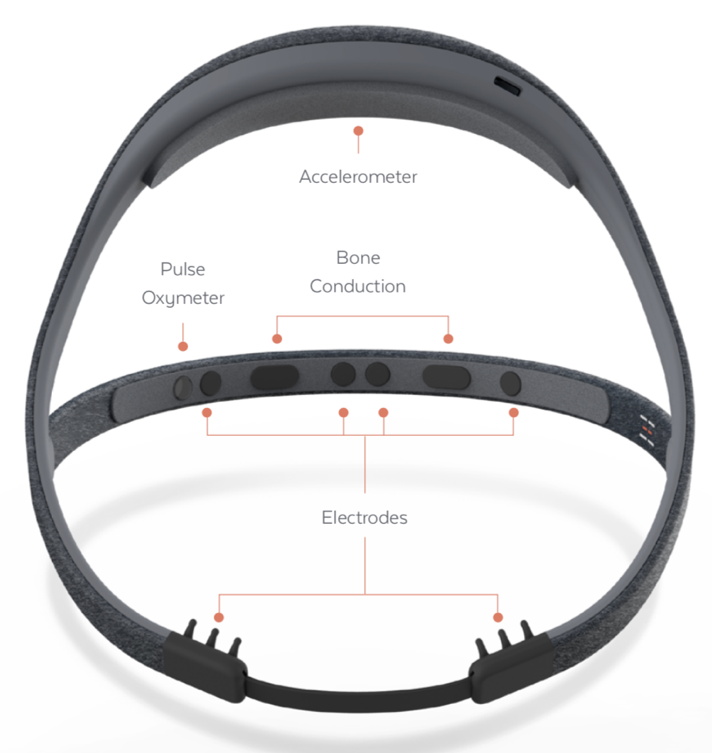

# Pipeline #

Our work is based on the method of the article "A Comparative Study on Classification of Sleep Stage Based on EEG Signals Using Feature Selection and Classification Algorithms" from Baha Şen & Musa Peker & Abdullah Çavuşoğlu & Fatih V. Çelebi [5] and the features from the article "Sleep Stage Classification Using EEG Signal Analysis: A Comprehensive Survey and New Investigation" from Khald Ali I. Aboalayon 1, Miad Faezipour 1, [4].

In Addition, we applied Power Spectral Density on our data, based on the article "Chambon, Stanislas, Mathieu N. Galtier, Pierrick J. Arnal, Gilles Wainrib, et Alexandre Gramfort. « A Deep Learning Architecture for Temporal Sleep Stage Classification Using Multivariate and Multimodal Time Series ».[6]

The design of the pipeline is based on pre-processing, features extraction and selection, and classification. Features are extracted from both Train and Test data. The model is trained on Training Data from which features have been selected. 

# Libraries and global variables #

In [1]:
########################import libraries###################


# common libraries
from typing import Union, Tuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math as m

# file management
import pandas
import h5py

# signal processing
from scipy import signal, ndimage, stats
import antropy
import mne
from mne.time_frequency import psd_welch
import eeglib
import pywt

# sklearn
import sklearn
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV


########################global variables###################

NB_WINDOW = 15000
NB_SAMPLES = 1500
NB_EEG = 5
NB_ACC = 3

# Pre-processing #

Each EEG channel is filtered with a 8-order butterworth band-pass filter which is commonly used in sleep-stage classification. With this filter, we divided our signals into subbands that correspond to biologically relevant frequency bands in Hz : Delta (0.5-4), Theta (4-8), Alpha (8-12), Spindle (12-16), Beta (16-35). However, those frequency bands can largely vary interindividually and this variability can affect the prediction quality. According to the Shannon criteria, the sampling frequency should be at least twice higher than the signal frequenct. Therefore, due to the sampling frequency of the data, it becomes difficult to extract Spindle and Beta waves.

In [2]:
def butterworth_filter(eeg: np.ndarray, fc: Union[float, Tuple[float]], typ: str)->np.ndarray:
    """
    Takes an eeg array and computes the filtered eeg using a butterworth low or band pass filter. 
    Returns the filtered eeg. 
    """
    sos = signal.butter(8, fc, typ, fs=50, output='sos')
    filtered = signal.sosfilt(sos, eeg)
    return filtered


def eeg_bands(X: dict)->dict:
    """
    Takes a dictionnary containing each X channel and filteres each eeg channel within each frequency band. 
    Returns a dictionnary of dictionnaries containing each eeg channel filtered within each frequency band. 
    """
    # creation of filtered signal dictionnaries
    eeg_1 = {}
    eeg_2 = {}
    eeg_4 = {}
    eeg_5 = {}
    eeg_6 = {}

    # gathering of those dictionnaries
    eeg_f = {"eeg_1": eeg_1, "eeg_2": eeg_2,
             "eeg_4": eeg_4, "eeg_5": eeg_5, "eeg_6": eeg_6}

    band_names = ["Global", "Dela1_k_complexes", "Delta", "Theta", "Alpha", "Spindle", "Beta"]
    fc = {"Global": 0.5, "Dela1_k_complexes": (0.5, 2), "Delta": (2, 4), "Theta": (4, 8), "Alpha": (8, 12), "Spindle": (12, 16), "Beta": 16}

    nb_window = X['eeg_1'].shape[0]
    
    for key, value in eeg_f.items():
        for name in band_names:
            if name == "Beta" or name == "Global":
                # due to the sampling frequency, this band is not going to be well extracted
                value[name] = butterworth_filter(X[key], fc[name], "lowpass")
            else:
                value[name] = butterworth_filter(X[key], fc[name], "bandpass")
    return eeg_f

# Feature extraction #

## Power Spectral Density ##

First, we extracted the Power Spectral Density (PSD). The PSD of a signal describes the power present in the signal as a function of frequency. It is defined by Fourier Transform squared module divided by Spectral band width.

In [3]:
def eeg_power_band(X: dict)->np.ndarray:
    """
    Takes a dictionnary containing each X channel and filters each eeg channel within each frequency band. 
    Returns a dictionnary of dictionnaries containing each eeg channel filtered within each frequency band. 
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}
    
    channel_i = 0
    
    # gather all the channels in one array
    all_eeg = np.zeros((NB_WINDOW, NB_EEG, NB_SAMPLES))
    for key_eeg, eeg_i in X.items():
        if key_eeg == 'eeg_1' or key_eeg == 'eeg_2' or key_eeg == 'eeg_4' or key_eeg == 'eeg_5' or key_eeg == 'eeg_6':
            all_eeg[:,channel_i,:] = eeg_i
            channel_i+=1
            
    # creating information about the EEGs
    info = mne.create_info(['eeg_1', 'eeg_2', 'eeg_4', 'eeg_5', 'eeg_6'], sfreq = 50, ch_types = 'eeg')
    # creating epochs datatype from the EEGs data
    epochs = mne.EpochsArray(all_eeg, info)

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    # normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    # PSD classified by frequency bands and averaged on EEG channels
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

## EEG features ##

EEG features are based on the review "Sleep Stage Classification Using EEG Signal Analysis:
A Comprehensive Survey and New Investigation" from Khald Ali I. Aboalayon 1, Miad Faezipour 1 [4]

In their work, they segmente the signal in the time domain into sub-windows to apply Maximum-Minimum Distance (MMD) which corresponds to the sum distance between highest and lowest points. They also apply EnergySis (Esis), which determines the energy and speed of the EEG. 

In [4]:
def mmd(eeg: np.ndarray)->float:
    """
    Takes an eeg array and computes the Maximum-Minimum Distance (MMD). 
    Returns the sum of MMD for all sub-windows.
    """
    # wave length of the window
    lambda_ = 100
    nb_sub_window = int(NB_SAMPLES/lambda_)
    d = np.zeros(NB_WINDOW, nb_sub_window)
    for sub_window_i in range(nb_sub_window):
        # selection of the sub-window
        current = eeg[:,lambda_*sub_window_i:lambda_*(sub_window_i+1)]
        maxi = np.max(current, axis=1)
        maxi_ind = np.argmax(current, axis=1)
        mini = np.min(current, axis=1)
        mini_ind = np.argmin(current, axis=1)
        # distance computation for sub-window
        d[:,sub_window_i] = np.sqrt((maxi_ind - mini_ind)**2 + (maxi - mini)**2)
    # sum of all sub-windows
    return np.sum(d, axis=1)



def esis(eeg: np.ndarray, w1: float, w2: float)->float:
    """
    Takes an eeg array and computes the EnergySis (Esis) metric. 
    Returns Esis. 
    """
    # w1 and w2 correspond to the EEG frequencies of defined subbands
    lambda_ = 100
    v = lambda_*(w1 + w2)/2
    esis = np.sum(eeg**2, axis=1)*v
    return esis

A discrete wavelet transform (DWT) is a transform that decomposes a given signal into a number of sets, where each set is a time series of coefficients describing the time evolution of the signal in the corresponding frequency band.
This is a transformation method developed to overcome the deficiencies of the Fourier transformation over
non-stationary signals and this method is less sensitive towards noise and can be easily applied to non-stationary signals. 
With several level of transform, Details (D) and Approximated (A) coefficients are calculated.
As the authors do, we focused on the D3, D4, D5 and A5 coefficients. We also selected 'db4' (Daubechies of order 4) and level = 5. The WaveletPacket allows to have better features extraction for numerous EEG data. 


The features to be extracted are:
1. Mean of the absolute values of the coefficients in each sub-band (D3-1, D4-1, D5-1, and A5-1).
2. Average power of the wavelet coefficients in each sub-band (D3-2, D4-2, D5-2, and A5-2).
3. Standard deviation of the coefficients in each sub-band (D3-3, D4-3, D5-3, and A5-3).
4. Ratio of the absolute mean values of adjacent sub-bands (D3-4, D4-4, D5-4, and A5-4)

In [5]:
def Wavelet(eeg: np.ndarray)->list:
    """
    Takes an eeg array and computes the features describe below thanks to discrete wavelet transform. 
    Returns a list of those features. 
    """
    # definition of the wavelets packets
    wp = pywt.WaveletPacket(eeg, wavelet = 'db4', mode='symmetric', maxlevel=5, axis=1)
    # coefficients of interest
    aad = wp['aad'].data #D3
    aaaa = wp['aaaa'].data 
    aaad = wp['aaad'].data #D4
    aaaad = wp['aaaad'].data #D5
    aaaaa = wp['aaaaa'].data #A5
      
    re = [] 
    for i in ['aad','aaad','aaaad','aaaaa']:
        re.append(wp[i].data)
    # energy feature 
    wp_features = [] 
    for i, x in enumerate(re):
        wp_features.append(pow(np.linalg.norm(x,ord=None, axis=1),2))
    # mean values of coefficients
    mean_value_D3_1 = np.mean(aad, axis=1)
    mean_value_D4_1 = np.mean(aaad, axis=1)
    mean_value_D5_1 = np.mean(aaaad, axis=1)
    mean_value_A5_1 = np.mean(aaaaa, axis=1) 
    
    wp_features.append(mean_value_D3_1)
    wp_features.append(mean_value_D4_1)
    wp_features.append(mean_value_D5_1)
    wp_features.append(mean_value_A5_1)
    
    # standard deviation values of coefficients
    deviation_D3_3 = np.std(aad, axis=1)
    deviation_D4_3 = np.std(aaad, axis=1)
    deviation_D5_3 = np.std(aaaad, axis=1)
    deviation_A5_3 = np.std(aaaaa, axis=1)
    
    wp_features.append(deviation_D3_3)
    wp_features.append(deviation_D4_3)
    wp_features.append(deviation_D5_3)
    wp_features.append(deviation_A5_3)
    
    # mean ratios with adjacent subbands
    ratio_mean_D3_4 = mean_value_D3_1/mean_value_D4_1
    ratio_mean_D4_4 = mean_value_D4_1/mean_value_D5_1
    ratio_mean_D5_4 = mean_value_D5_1/mean_value_D4_1
    ratio_mean_A5_4 = mean_value_A5_1/np.mean(aaaa, axis=1)
    
    wp_features.append(ratio_mean_D3_4)
    wp_features.append(ratio_mean_D4_4)
    wp_features.append(ratio_mean_D5_4)
    wp_features.append(ratio_mean_A5_4)
    
    return wp_features

In [6]:
def basic_features_eeg(eeg: np.ndarray)->list:
    """
    Takes an eeg array and computes a set of basic features. 
    Returns a list of those features. 
    """
    minimum_value = np.min(eeg, axis=1)
    maximum_value = np.max(eeg, axis=1)
    mean_value = np.mean(eeg, axis=1)
    standard_deviation = np.std(eeg, axis=1, ddof=1)
    variance = np.var(eeg, axis=1, ddof=1)
    median = np.median(eeg, axis=1)
    skewness = stats.skew(eeg, axis=1)
    kurthosis = stats.kurtosis(eeg, axis=1)
    SpEn = antropy.spectral_entropy(eeg, sf=50, axis=1)
    zero_cross = antropy.num_zerocross(eeg, axis=1)

    # for functions that cannot treat data by axis
    pfd, Hjorth, hfd, lzc, ApEn, PEn = [], [], [], [], [], []
    for window_i in range(NB_WINDOW):
        pfd.append(eeglib.features.PFD(eeg[window_i,:]))
        Hjorth.append(eeglib.features.hjorthComplexity(eeg[window_i,:]))
        hfd.append(eeglib.features.HFD(eeg[window_i,:]))
        lzc.append(eeglib.features.LZC(eeg[window_i,:]))
        ApEn.append(antropy.sample_entropy(eeg[window_i,:]))
        PEn.append(antropy.perm_entropy(eeg[window_i,:]))
   
    feature_list = [minimum_value, maximum_value, mean_value, standard_deviation,
             variance, median, skewness, kurthosis, pfd, SpEn, ApEn, PEn,
             Hjorth, zero_cross, hfd, lzc]

    return feature_list

In [7]:
def eeg_features(eeg_f: dict)->np.ndarray:
    """
    Takes the dictionnary of filtered eeg for each band and computes features for each band and each channel.
    Returns the mean of those features over all channels.  
    """
    band_names = ["Dela1_k_complexes", "Delta",
                  "Theta", "Alpha", "Spindle", "Beta1", "Beta2"]
    fc = {"Global": 0.5, "Dela1_k_complexes": (0.5, 2), "Delta": (
        2, 4), "Theta": (4, 8), "Alpha": (8, 12), "Spindle": (12, 16), "Beta": (16, 24)}

    nb_features = 16*6 + 2*6 + 16*6
    X_features = np.zeros((NB_WINDOW, NB_EEG, nb_features))
    
    channel_i = 0
    for key_eeg, eeg_i in eeg_f.items():
        print(key_eeg)
        effective_band_j = 0
        for key_band, band_i in eeg_i.items():
            if key_band != "Global":
                features = basic_features_eeg(band_i)
                MMD = mmd(band_i)
                features.append(MMD)
                esis_ = esis(band_i, fc[key_band][0], fc[key_band][1])
                features.append(esis_)
                wavelet_ = Wavelet(band_i)
                for wv in wavelet_:
                    features.append(wv)
                features = np.array(features).T
                
                X_features[:, channel_i, 34*effective_band_j:34*(effective_band_j+1)] = features
        
                effective_band_j+= 1
        channel_i += 1
    X_features = np.mean(X_features, axis=1)
    return X_features


## Accelerometer features ##

Accelerometers are included in the Dreem headband. They correspond to 3 accelerometer channels (x, y and z). Accelerometers monitor movement, and there is little difference in movement between  sleep stages.
  
x - Accelerometer along x axis sampled at 10 Hz, 300 values
y - Accelerometer along y axis sampled at 10 Hz, 300 values
z - Accelerometer along z axis sampled at 10 Hz, 300 values

In [8]:
def basic_features_acc(acc: np.ndarray)->list:
    """
    Takes an accelerometer array and computes a set of basic features.
    Returns a list of those features.  
    """
    minimum_value = np.min(acc, axis=1)
    maximum_value = np.max(acc, axis=1)
    mean_value = np.mean(acc, axis=1)
    standard_deviation = np.std(acc, ddof=1, axis=1)
    median_absolute_deviation = stats.median_abs_deviation(acc, axis=1)
    variance = np.var(acc, ddof=1, axis=1)
    median = np.median(acc, axis=1)
    skewness = stats.skew(acc, axis=1)
    kurthosis = stats.kurtosis(acc, axis=1)
    
    zero_cross = antropy.num_zerocross(acc, axis=1)
    SpEn = antropy.spectral_entropy(acc, sf=50, axis=1)
    
    
    feature_list = [minimum_value, maximum_value, mean_value, standard_deviation, median_absolute_deviation, 
           variance, median, skewness, kurthosis, zero_cross, SpEn]
    return feature_list

In [9]:
def acc_features(X: dict)->np.ndarray:
    """
    Takes the dictionnary of X channels and computes features for accelerometer channels.
    Returns the mean of those features over all accelerometer channels.  
    """
    nb_features = 11
    X_features = np.zeros((NB_WINDOW, NB_ACC, nb_features))
    
    keys = ['x', 'y', 'z']
    for key_acc, channel_i in enumerate(keys):
        features = basic_features_acc(X[key_acc])
        features = np.array(features).T
        
        X_features[:, channel_i, :] = features
    X_features = np.mean(X_features, axis=1)  
    return X_features


## Normalizing and gathering features ##


In [10]:
def normalize(X_features):
    """
    Takes the dictionnary of X channels and normalizes by feature. 
    Returns the normalized feature array.   
    """
    # remove non-values and infinite values 
    X_features = np.where(np.isnan(X_features), 0, X_features)
    X_features = np.where(X_features == np.inf, 0, X_features)
    # normalizing X
    return (X_features - np.mean(X_features, axis=0, keepdims=True))/np.std(X_features, axis=0, keepdims=True)

In [11]:
def function_transformer(X):
    """
    Takes the dictionnary of X channels and computes global features for accelerometer and eeg channels.
    Returns those features in an array.  
    """
    print("Getting frequency bands...")
    eeg_f = eeg_bands(X)
    
    print("Getting Power Spectral Density...")
    X_mne = eeg_power_band(X)
    
    print("Getting eeg features...")
    X_eeg_features = eeg_features(eeg_f)

    print("Getting accelerometers features...")
    X_acc_features = acc_features(X)
  
    X_features = np.concatenate((X_eeg_features, X_acc_features), axis=1)
    X_features = normalize(X_features)
    
    X_global_features = np.concatenate((X_mne,X_features), axis=1)
    return X_global_features

# Feature selection #

We obtained a large number of features. We now want to reduce them to obtain a more accurate model of the data, and thus obtain a better performance. 

We used a recursive feature elimination method by cross-validation loop. The algorithm evaluates at each step the set of features and finds one or more least significant features by cross-validation loop. 
Then it starts again until it estimates that all the remaining features are significant, which makes the classification more efficient and increases the performance of the model.
As this algorithm can be expensive, the executing time has been reduced by selecting the number of features to be eliminated at each iteration and using parallel processing.

In [12]:
def select_features(X: np.ndarray, y: np.ndarray, best_estimator: np.ndarray):
    """
    Performs recursive feature elimination that improves the model. 
    Returns the resulting feature selector. 
    """
    estimator = best_estimator
    
    # feature selection with cross validation
    selector = RFECV(estimator, n_jobs=-1, scoring='f1_macro', step= 7)
    selector = selector.fit(X,y)

    # selector contains information about the number of features selected
    # the ranking and if we should support them or not 
    return selector

# Classification procedure #

Random Forest is an algorithm that was first proposed by Leo Breiman in 2001. It is based on the generation of prediction trees taking into account a subpart of the data. 

During training, the algorithm randomly selects observation points (epochs) as well as features and builds a tree for each random sub-draw it has made. 
Each tree is trained on its data providing a partial model.

During the test, each subtree in the forest predicts the class to which the observation belongs. The majority class wins and this class is assigned to the data.

In [13]:
def best_params(train_features: np.ndarray, train_labels: np.ndarray):
    """
    Performs a random search to find the Random Forest Classifier (with hyper-parameters) that fits best the data. 
    Returns the result of this search. 
    """
    # number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 50)]
    # number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
    # minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # method of selecting samples for training each tree
    bootstrap = [True, False]
    class_weight = ["balanced", "balanced_subsample"]
    # create the random grid
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}
    # use the random grid to search for best hyperparameters
    # first create the base model to tune
    rf = RandomForestClassifier()
    # random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # fit the random search model
    rf_random.fit(train_features, train_labels)
    
    return rf_random

# Main function #

In [14]:
def main():
    # open files
    with open('y_train.csv', 'r') as file_ytrain:
        ytrain = pandas.read_csv(file_ytrain)
        Xtrain = h5py.File('X_train.h5', 'r')
        Xtest = h5py.File('X_test.h5', 'r')

        # 3 accelerometers
        x = Xtrain['x']
        y = Xtrain['y']
        z = Xtrain['z']

        # index
        index = Xtrain['index']
        ind = [1, 2, 4, 5, 6]

        ytrain = ytrain.iloc[:,1]

        print("Perfoming feature extraction for the training set...")
        # get features
        X_features_train = function_transformer(Xtrain)
        
        print("Performing feature extraction for the testing set...")
        X_features_test = function_transformer(Xtest)
        
        # find roughly the best parameters for the model to use it to select features
        best = best_params(X_features_train, ytrain)

        # find best features for the model
        selected = select_features(X_features_train, ytrain, best.best_estimator_)
        
        # selected.support_ is a list of booleans that tells which feature we should keep
        X_features_train_reduced = np.delete(X_features_train, np.where(selected.support_ == False), axis=1)
        X_features_test_reduced = np.delete(X_features_test, np.where(selected.support_ == False), axis=1)
        
        # find roughly the best parameters for the reduced model
        best = best_params(X_features_train_reduced, ytrain)
        clf = best.best_estimator_
        
        scores = clf.cross_val_score(X_features_train_reduced, ytrain)
        print(f"The average score with cross validation was {np.mean(scores)}")
        
        clf.fit(X_features_train_reduced, ytrain)
        
        y_pred = clf.predict(X_features_test_reduced)
    
        # write the result in a CSV file
        C = {"index":[i for i in range(NB_WINDOW,NB_WINDOW + 6000)], "sleep_stage" : y_pred}
        data = pandas.DataFrame(C)
        export_csv = data.to_csv('submission_v3.csv', index = None, header = True,
                         encoding = 'utf-8', sep = ',')
        print("Output written.")

# Conclusion #

In the context of Dreem headbands, we developped an algorithm of sleep staging able to differentiate between Wake, N1, N2, N3 and REM on windows of 30 seconds of raw data, with 5 EEG channels in frontal and occipital position and 3 accelerometers channels (x, y and z). 
We extracted features based on different articles. We used the RandomForest Classifier and recursive feature elimination with cross validation to eliminate unrelevant features.

This algorithm allows to classify sleep stages according to accelerometer and eeg recordings. 
Our F1-Score is 0.62333.



# Bibliography #

[1] Rundo, J.V., and Downey, R. (2019). Polysomnography. Handb Clin Neurol 160, 381–392. 

[2] Domingues, A., Paiva, T., and Sanches, J.M. (2014). Hypnogram and sleep parameter computation from activity and cardiovascular data. IEEE Trans Biomed Eng 61, 1711–1719. 

[3] Arnal, P.J., Thorey, V., Debellemaniere, E., Ballard, M.E., Bou Hernandez, A., Guillot, A., Jourde, H., Harris, M., Guillard, M., Van Beers, P., et al. (2020). The Dreem Headband compared to polysomnography for electroencephalographic signal acquisition and sleep staging. Sleep 43, zsaa097. 

[4] Aboalayon, Khald Ali I., Miad Faezipour, Wafaa S. Almuhammadi, et Saeid Moslehpour. « Sleep Stage Classification Using EEG Signal Analysis: A Comprehensive Survey and New Investigation ». Entropy 18, nᵒ 9 (septembre 2016): 272. https://doi.org/10.3390/e18090272.

[5] Şen, Baha, Musa Peker, Abdullah Çavuşoğlu, et Fatih V. Çelebi. « A Comparative Study on Classification of Sleep Stage Based on EEG Signals Using Feature Selection and Classification Algorithms ». Journal of Medical Systems 38, nᵒ 3 (mars 2014): 18. https://doi.org/10.1007/s10916-014-0018-0.

[6] Chambon, Stanislas, Mathieu N. Galtier, Pierrick J. Arnal, Gilles Wainrib, et Alexandre Gramfort. « A Deep Learning Architecture for Temporal Sleep Stage Classification Using Multivariate and Multimodal Time Series ». IEEE Transactions on Neural Systems and Rehabilitation Engineering 26, nᵒ 4 (avril 2018): 758‑69. https://doi.org/10.1109/TNSRE.2018.2813138.
